# 1 - Locally Linear Embedding

## Get the data

First lets load the MNIST data. All the training and test samples are going to be used.

In [1]:
import numpy as np
from io_data import load_mnist

# img_train, lbl_train = load_mnist(dataset='training')
img_test,  lbl_test  = load_mnist(dataset='testing')
data   = img_test #np.vstack([img_train, img_test])
labels = lbl_test #np.concatenate([lbl_train, lbl_test])
# Convert the images samples into vectors
data = data.reshape((data.shape[0], -1))

print('Data shape:\t{}'.format(data.shape))
print('Labels shape:\t{}'.format(labels.shape))

Data shape:	(10000, 784)
Labels shape:	(10000,)


## Locally Linear Embedding
The implementation of the algorithm is at `locally_linear_embedding.py` file which computes the embedding for the given data. Lets compute the 2D and 3D embedings for 1000 samples of the MNIST dataset.

In [2]:
from locally_linear_embedding import *

N = 1000

X = data[:N].astype('float') / 255
labels = labels[:N]

n_neighbors = 8

Y_2d, e_error_2, r_error_2, M_2 = locally_linear_embedding(X, n_components=2, n_neighbors=n_neighbors)
Y_3d, e_error_3, r_error_3, M_3 = locally_linear_embedding(X, n_components=3, n_neighbors=n_neighbors)
print('For the 2D Locally Linear Embedding the embedding error has been: {:.6f} and the reconstruction error is: {}'
      .format(e_error_2, r_error_2))
print('For the 3D Locally Linear Embedding the embedding error has been: {:.6f} and the reconstruction error is: {}'
      .format(e_error_3, r_error_3))

For the 2D Locally Linear Embedding the embedding error has been: 0.000220 and the reconstruction error is: 17300.081263944005
For the 3D Locally Linear Embedding the embedding error has been: 0.000516 and the reconstruction error is: 17300.081263944005


Now visualize the embedding in a 2D plot.

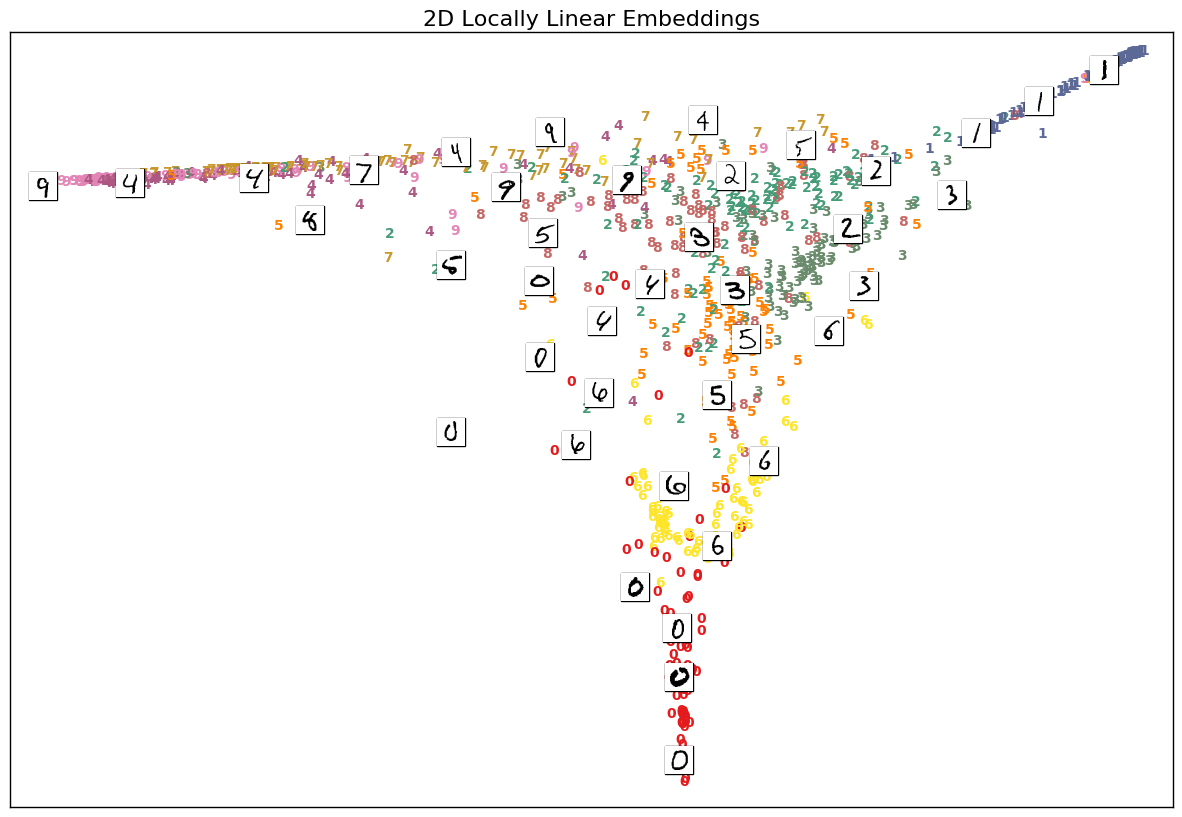

In [3]:
%matplotlib inline
from visualization import *

plot_embedding(Y_2d, X.reshape(X.shape[0], 28, 28), labels, title='2D Locally Linear Embeddings')
plt.savefig('../report/images/2d_embeddings.png', bbox_inches='tight')
plt.show()

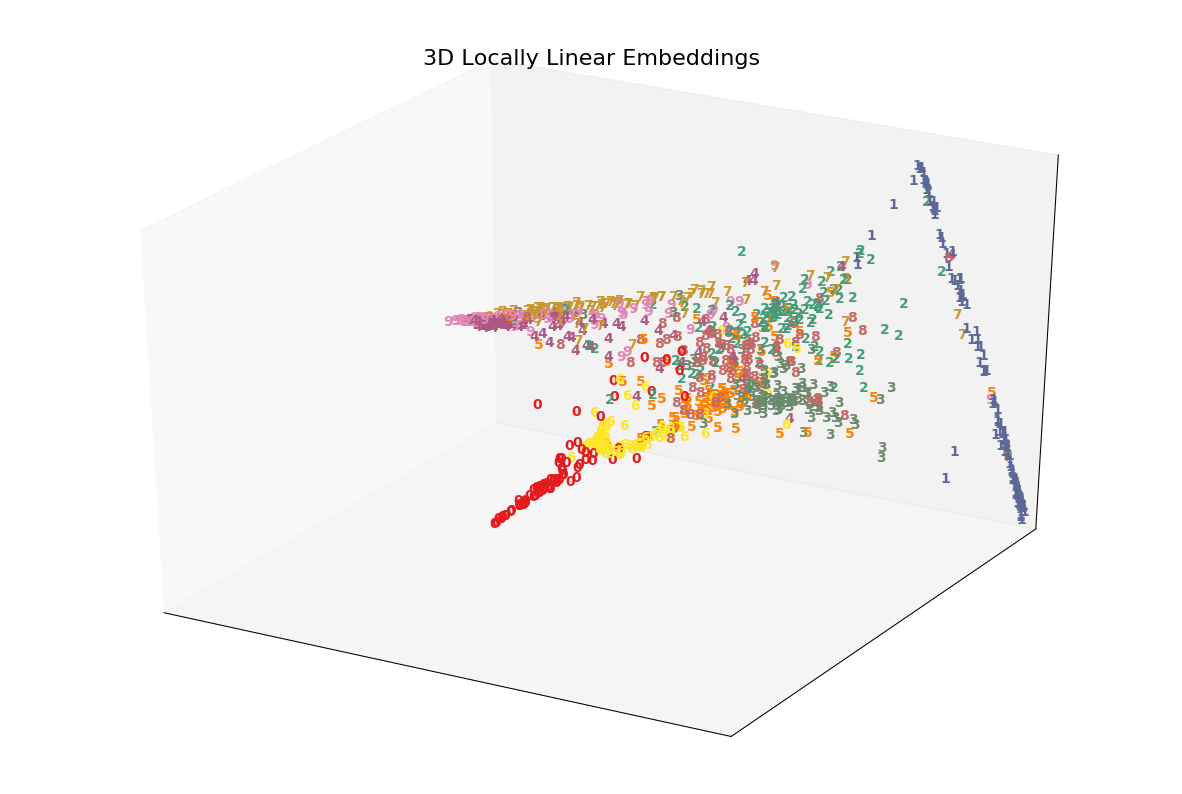

In [4]:
from visualization import plot_embedding_3d

plot_embedding_3d(Y_3d, labels, title='3D Locally Linear Embeddings')
plt.savefig('../report/images/3d_embeddings.png', bbox_inches='tight')
plt.show()

In the resulting embeding some clusters can be observed which for example the cluster of 1s is more distant to the rest of the digits as it is the most different to the rest. On the other hand we have 0s an 6s very close to each other as its form is very close. The same happends with 4s and 9s which tent to be more distant. In the centre the rest of the digits remain close because of its similarity but not very mixed with each other.

## Cluster Structure

Now lets investigate the cluster structure of the data. First lets plot the $M$ matrix.

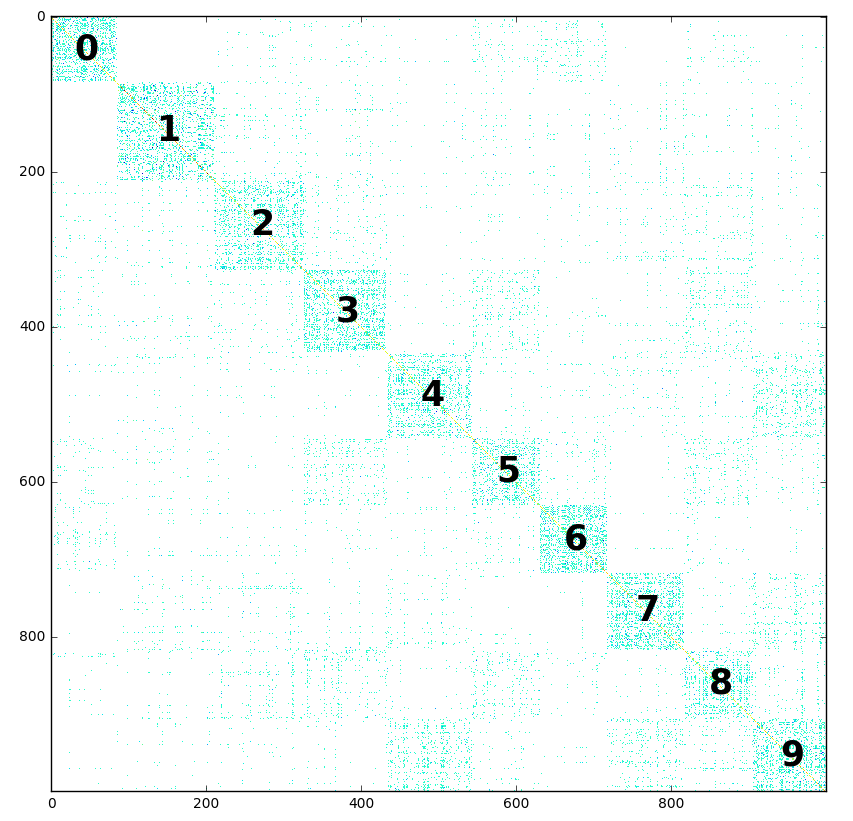

In [5]:
import matplotlib.pyplot as plt

# M matrix transformation
M = M_2.copy()
M[np.where(M==0)] = np.nan
# Sort points depending on its label
idx = np.argsort(labels)
M = M[idx,:][:,idx]

plt.figure(figsize=(15,10), dpi=300)
plt.imshow(M, interpolation='none')

count = 0
for i in range(10):
    c = np.sum(labels==i)
    pos = count + c//2
    plt.text(pos-12.5,pos+12.5, str(i), fontdict={'weight': 'bold', 'size':25})
    count += c
plt.savefig('../report/images/matrix_clusters.png', bbox_inches='tight')
plt.show()

At the previous matrix plots, some clusters can be observed, being a lot of correlation between samples of the same digit, and also some cross correlations between digits such as between 4 and 9 or 3 and 5 for example. This results are consistent with the clusters observed at the embedings.

Also I am going to find all the eigenvalues of $M$ matrix and plot them.

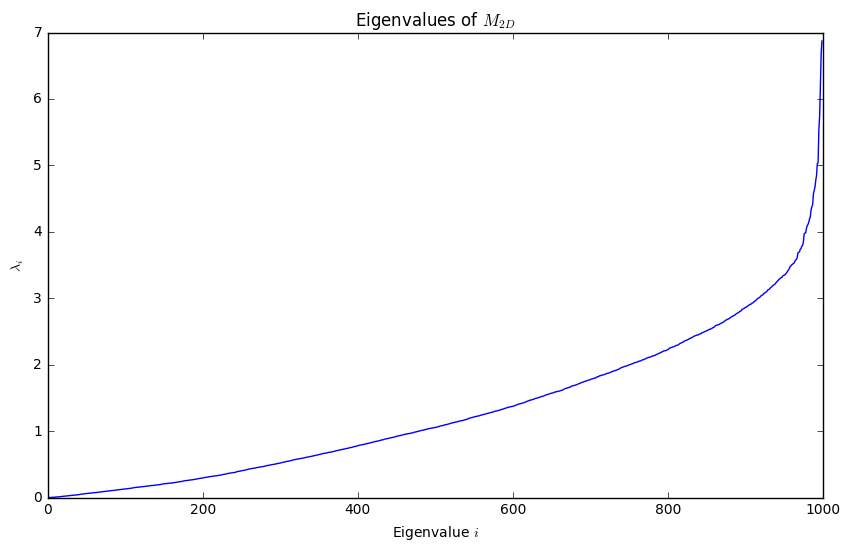

In [6]:
from scipy.linalg import eigh

eigen_values = eigh(M_2, eigvals_only=True)

plt.figure(figsize=(10,6), dpi=300)
plt.plot(np.arange(eigen_values.shape[0]), eigen_values)
plt.title('Eigenvalues of $M_{2D}$')
plt.xlabel('Eigenvalue $i$')
plt.ylabel('$\lambda_i$')
plt.savefig('../report/images/matrix_eigenvalues.png', bbox_inches='tight')
plt.show()

As it can be seen, the eigenvalues tent to be small and the start increassing a lot once the output dimension of the embedding becomes higher of the original dimension space.

To see this better lets plot the reconstructions error depending on the output dimension choosen which computation is the same as make an accumulative sum of the eigenvalues.

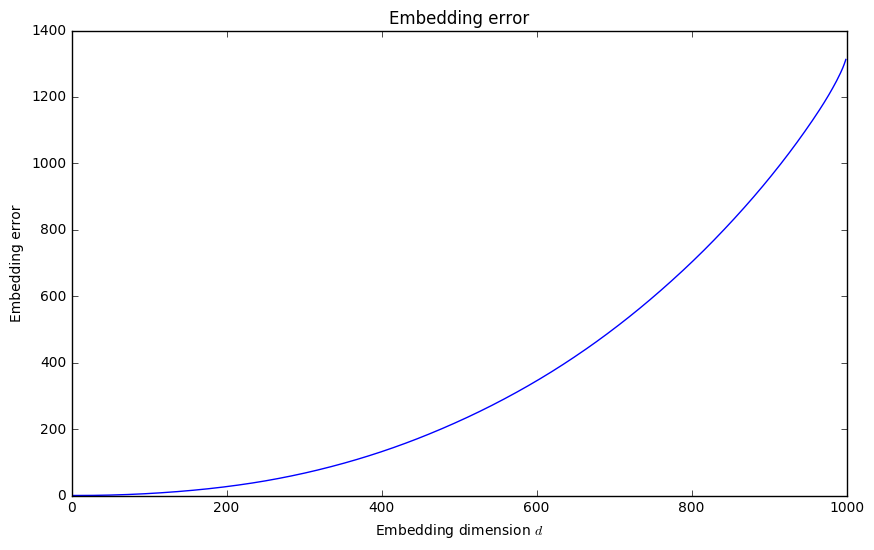

In [7]:
r_error_cum = np.cumsum(eigen_values)

plt.figure(figsize=(10,6), dpi=300)
plt.plot(np.arange(r_error_cum.shape[0]), r_error_cum)
plt.title('Embedding error')
plt.xlabel('Embedding dimension $d$')
plt.ylabel('Embedding error')
plt.show()

## Nearest Neighbors

To find the most suitable value for the nearest neighbors lets plot the reconstruction error versus the number of nearest neighbors choosen.

In [8]:
k_neighbors = np.round(np.linspace(2, 50, 25)).astype(np.int)

r_error = np.empty(k_neighbors.shape)

for i, k in enumerate(k_neighbors):
    Y, _, r_error[i], _ = locally_linear_embedding(X, n_components=10, n_neighbors=k)
    #r_error[i] = reconstruction_error(X, Y, n_neighbors=k)
    print('{} nearest neighbors\treconstruction error: {}'.format(k, r_error[i]))

2 nearest neighbors	reconstruction error: 23826.727827630802
4 nearest neighbors	reconstruction error: 19642.670628873613
6 nearest neighbors	reconstruction error: 18132.25371298038
8 nearest neighbors	reconstruction error: 17300.081263944005
10 nearest neighbors	reconstruction error: 16650.215142985784
12 nearest neighbors	reconstruction error: 16166.239653728177
14 nearest neighbors	reconstruction error: 15693.09528113985
16 nearest neighbors	reconstruction error: 15281.73616212923
18 nearest neighbors	reconstruction error: 14886.095412280534
20 nearest neighbors	reconstruction error: 14529.148358199605
22 nearest neighbors	reconstruction error: 14161.416153582633
24 nearest neighbors	reconstruction error: 13781.434565040721
26 nearest neighbors	reconstruction error: 13430.25956632323
28 nearest neighbors	reconstruction error: 13109.247455824032
30 nearest neighbors	reconstruction error: 12792.428121913996
32 nearest neighbors	reconstruction error: 12501.123849985617
34 nearest neigh

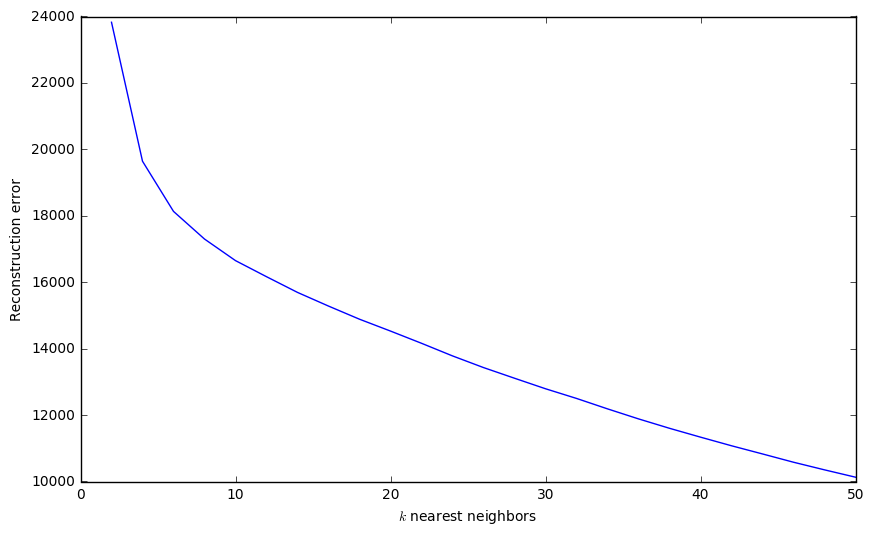

In [9]:
plt.figure(figsize=(10,6), dpi=300)
plt.plot(k_neighbors, r_error)
plt.xlabel('$k$ nearest neighbors')
plt.ylabel('Reconstruction error')
plt.savefig('../report/images/reconstruction_error_knn.png', bbox_inches='tight')
plt.show()

Now lets change the metric used by the Locally Linear Embedding and see the differences of the 2D and 3D embeddings.

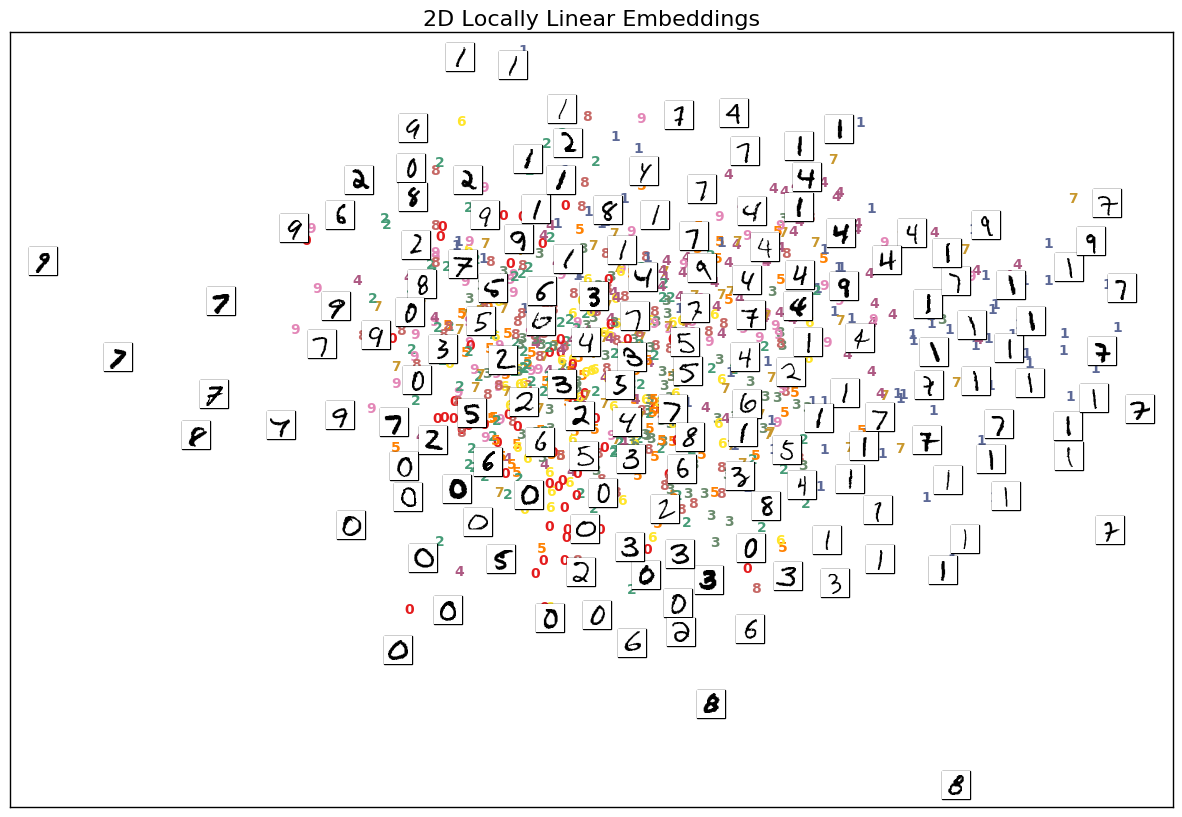

In [10]:
Y_50_nn_2d, _, _, _ = locally_linear_embedding(X, n_components=2, n_neighbors=50)
plot_embedding(Y_50_nn_2d, X.reshape(X.shape[0], 28, 28), labels, title='2D Locally Linear Embeddings')
plt.savefig('../report/images/2d_embeddings_50_nn.png', bbox_inches='tight')
plt.show()


In [18]:
from scipy.spatial.distance import correlation, cosine
metric=correlation
Y_corr_2d, _, _, _ = locally_linear_embedding(X, n_components=2, n_neighbors=n_neighbors, metric=metric)
metric=cosine
Y_cos_2d, _, _, _ = locally_linear_embedding(X, n_components=2, n_neighbors=n_neighbors, metric=metric)
metric='l1'
Y_l1_2d, _, _, _ = locally_linear_embedding(X, n_components=2, n_neighbors=n_neighbors, metric=metric)

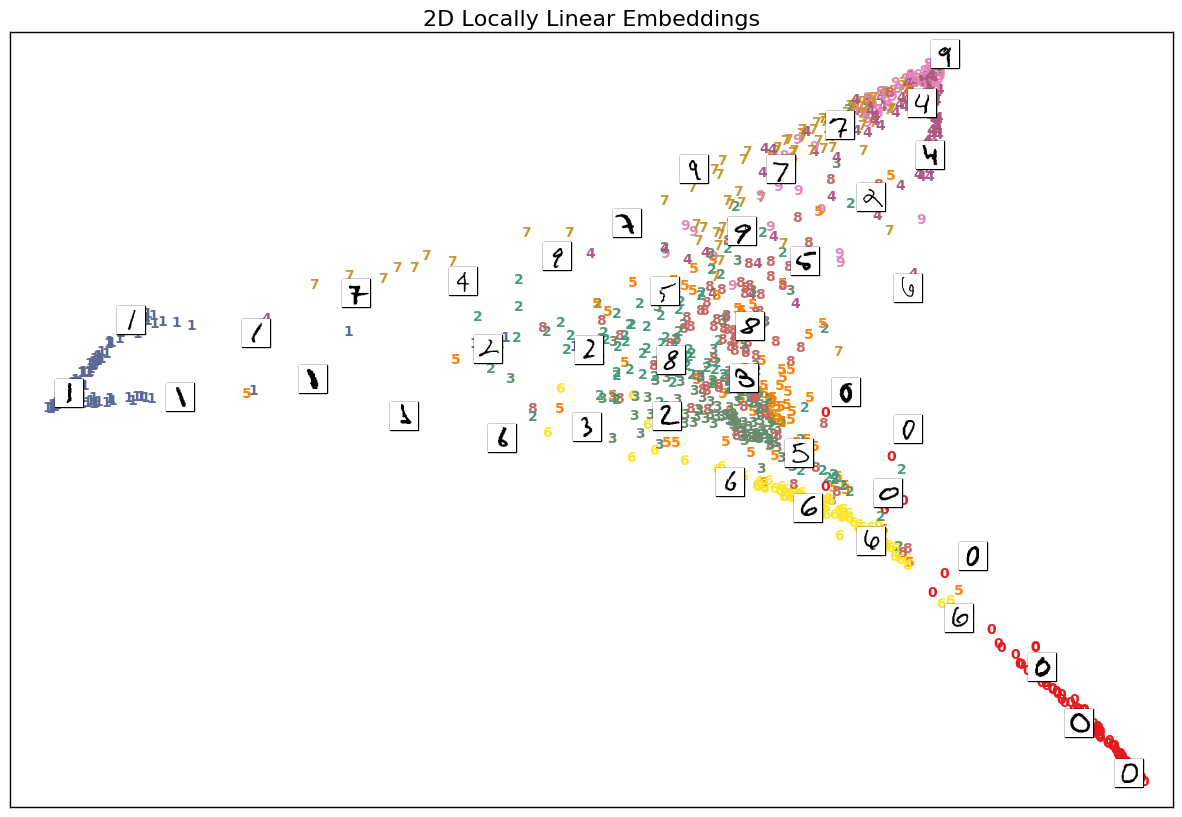

In [20]:
plot_embedding(Y_corr_2d, X.reshape(X.shape[0], 28, 28), labels, title='2D Locally Linear Embeddings')
plt.savefig('../report/images/2d_embeddings_correlation_metric.png', bbox_inches='tight')
plt.show()

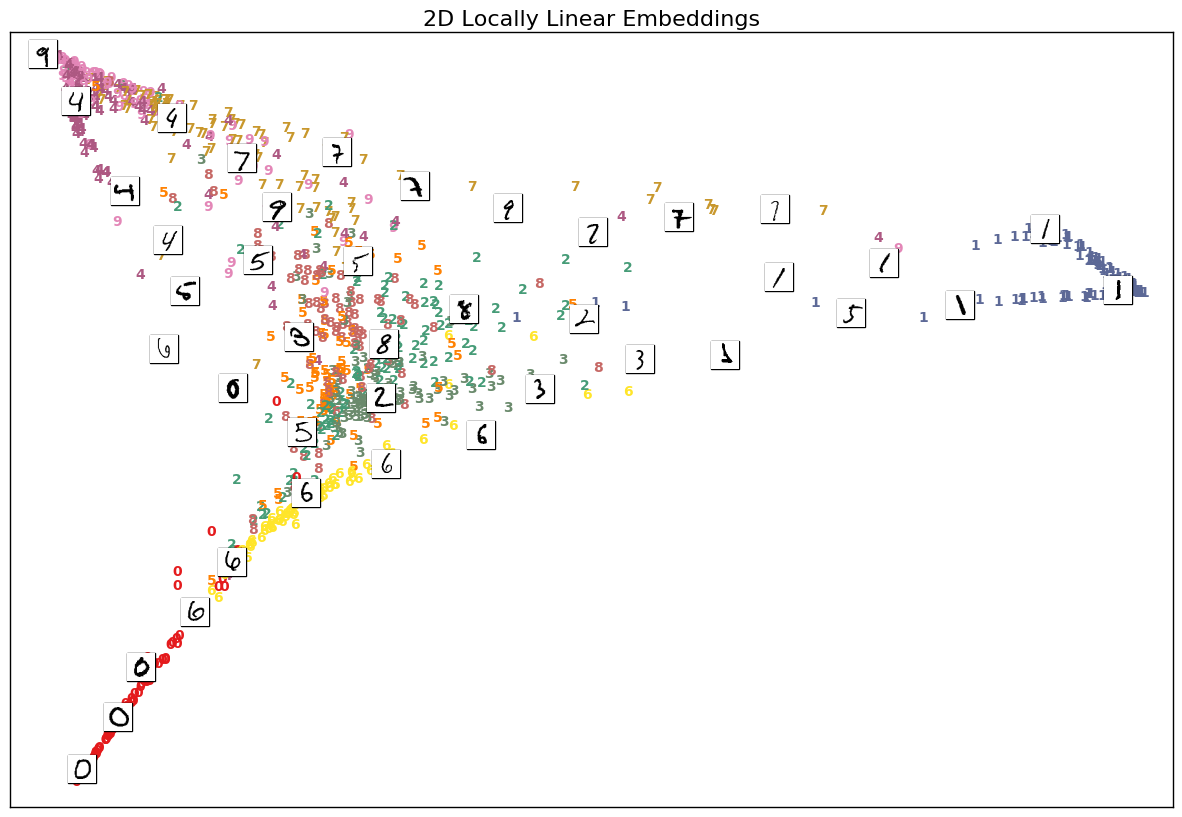

In [21]:
plot_embedding(Y_cos_2d, X.reshape(X.shape[0], 28, 28), labels, title='2D Locally Linear Embeddings')
plt.savefig('../report/images/2d_embeddings_cosine_metric.png', bbox_inches='tight')
plt.show()

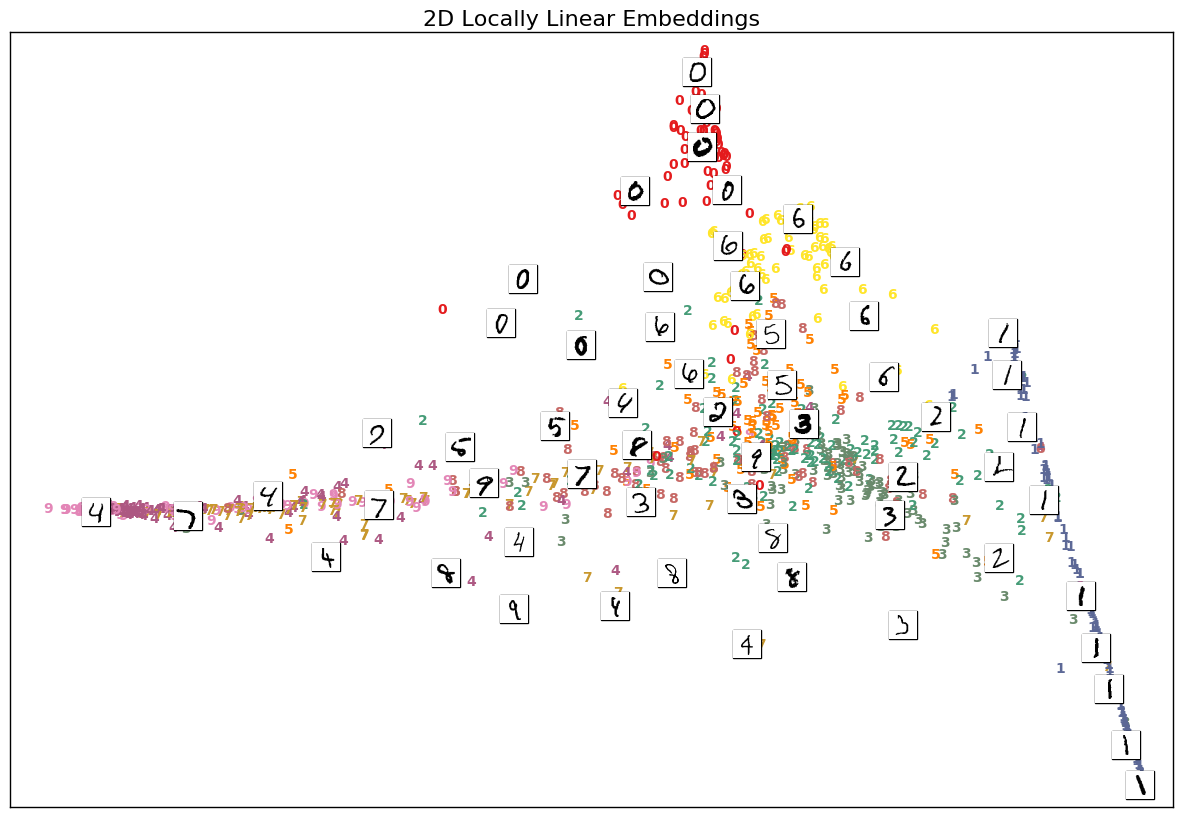

In [22]:
plot_embedding(Y_l1_2d, X.reshape(X.shape[0], 28, 28), labels, title='2D Locally Linear Embeddings')
plt.savefig('../report/images/2d_embeddings_l1_metric.png', bbox_inches='tight')
plt.show()

## Linear Manifold Interpolation

Now lets try to reconstruct a point from the embedding space into the original space. First lets choose a point inside the manifold.

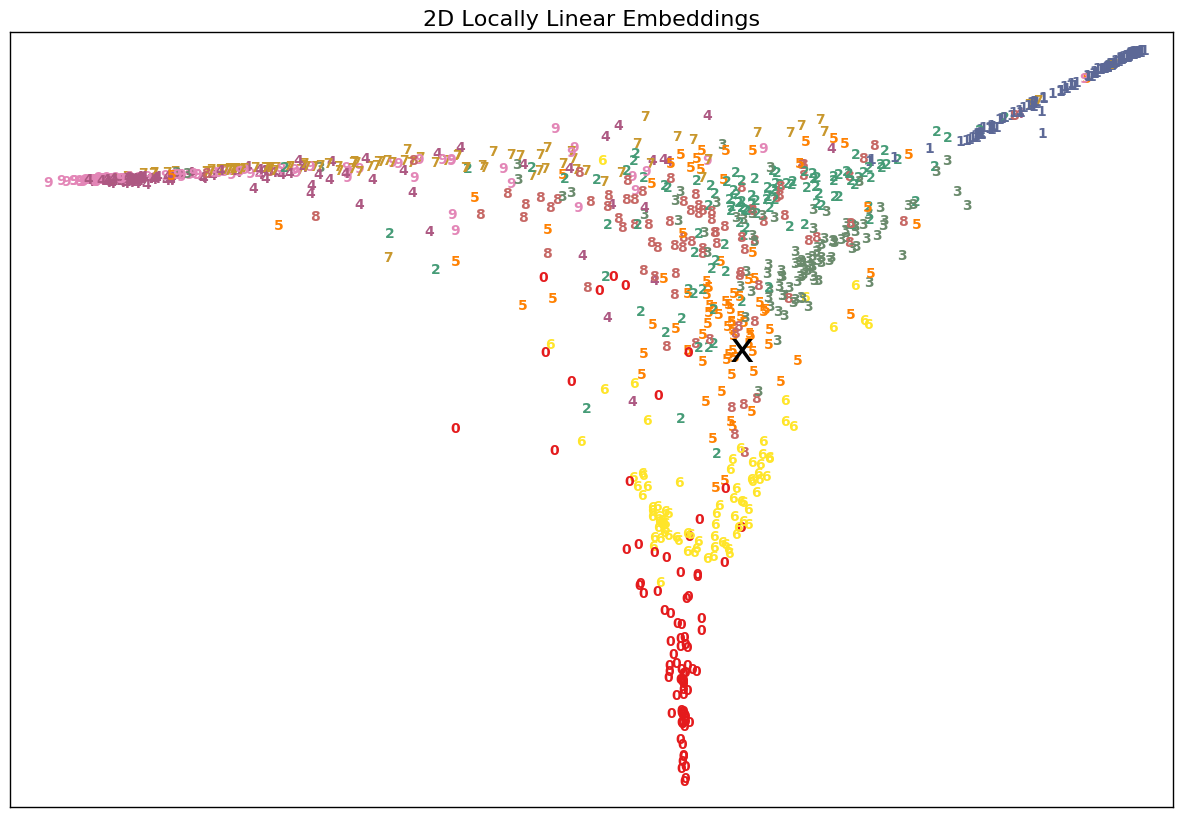

In [23]:
y_min, y_max = Y_2d.min(0, keepdims=True), Y_2d.max(0, keepdims=True)
y = Y_2d[23]

plot_embedding(Y_2d, X.reshape(X.shape[0], 28, 28), labels, title='2D Locally Linear Embeddings', 
               attach_images=False)
plt.text(y[0],y[1], 'x', fontsize=30)
plt.show()

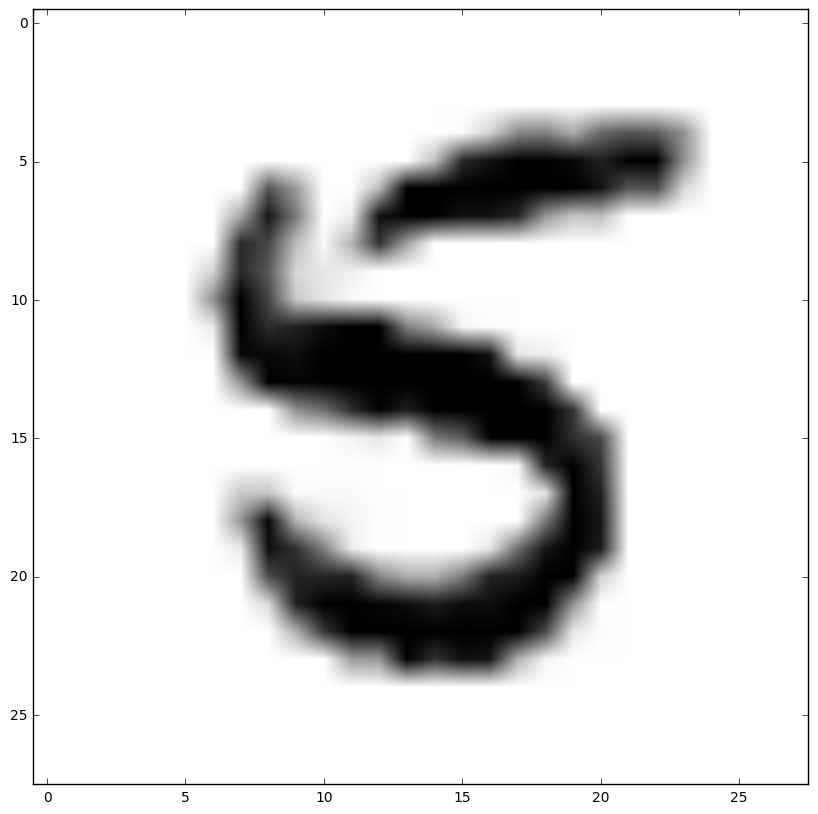

In [24]:
from locally_linear_embedding import embedding_reconstruction
from visualization import plot_digit

X_rec = embedding_reconstruction(y, Y_2d, X, n_neighbors=n_neighbors)

X_rec[X_rec > 1] = 1
X_rec[X_rec < 0] = 0

plot_digit(X_rec)
plt.savefig('../report/images/reconstruction_inside_manifold.png', bbox_inches='tight')
plt.show()

Also choosing a point outside the manifold like the upper right most coordinate, far away from the manifold and see what the reconstruction is:

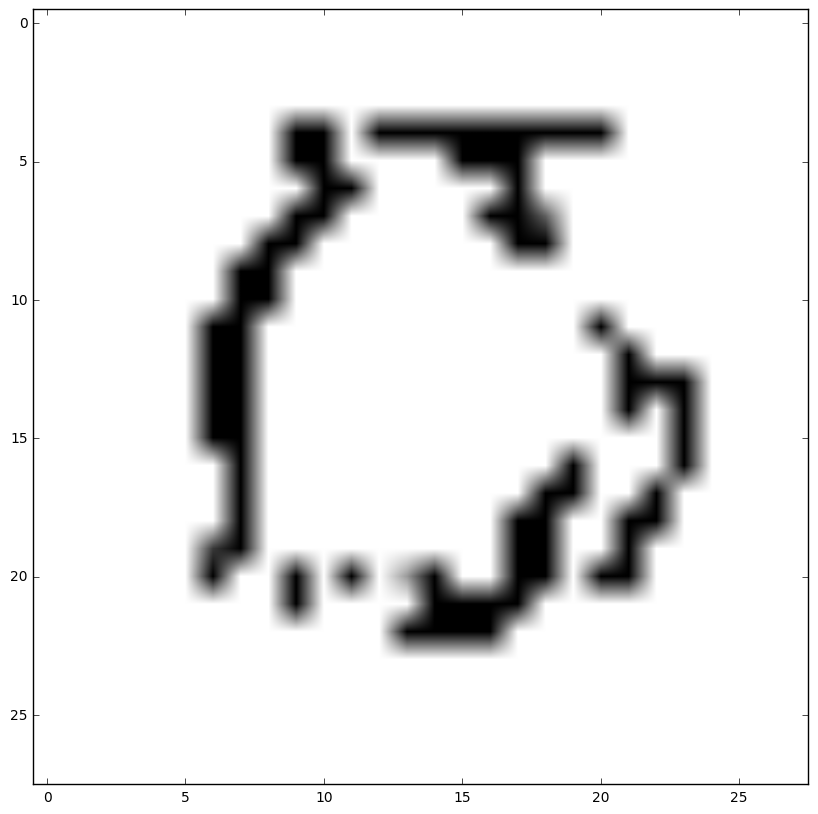

In [25]:
y = y_min
#y[0,1] = y_max[0,1]
X_rec_out = embedding_reconstruction(y, Y_2d, X, n_neighbors=n_neighbors)
X_rec_out[X_rec_out > 1] = 1
X_rec_out[X_rec_out < 0] = 0
plot_digit(X_rec_out)
plt.savefig('../report/images/reconstruction_outside_manifold.png', bbox_inches='tight')
plt.show()

Now lets draw a line between two samples and then reconstruct the images step by step and see how it evolves.

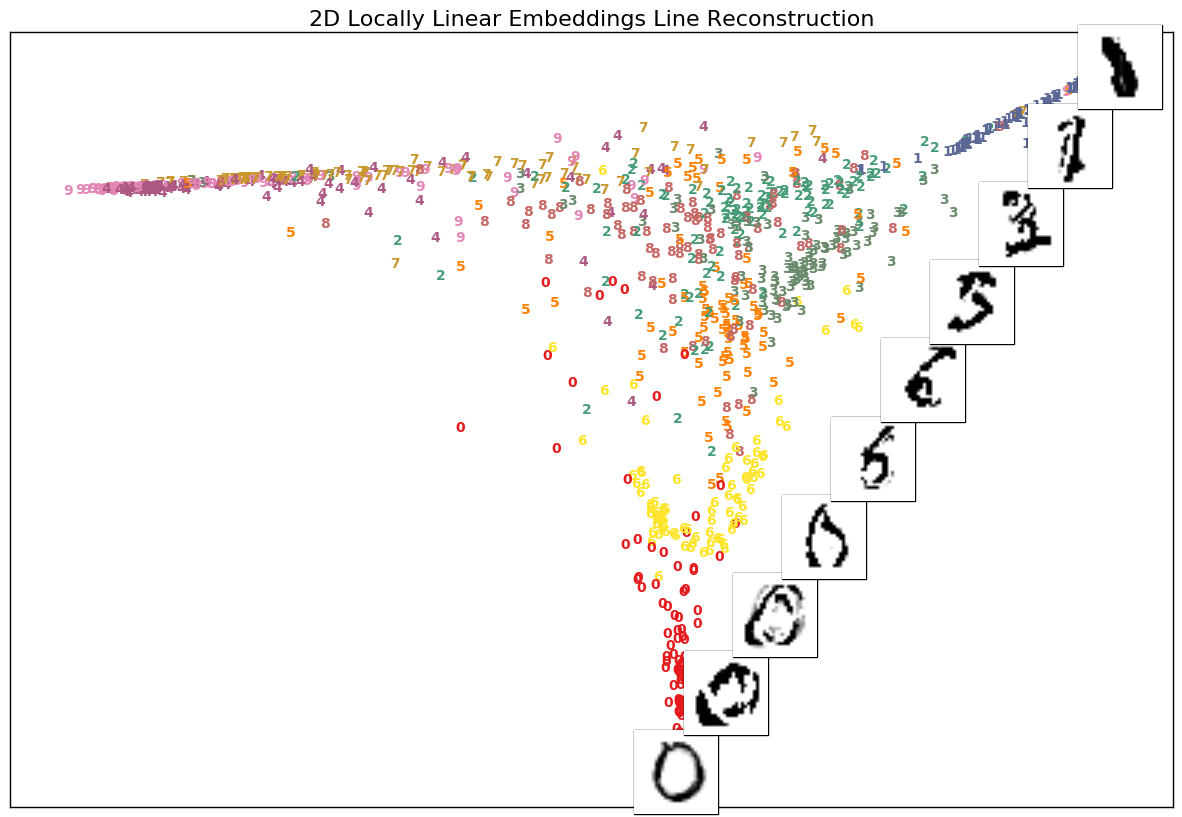

In [26]:
from visualization import *

# Look for two appropiate endpoints
y_start = Y_2d[np.where(Y_2d[:,1]==np.min(Y_2d[:,1])),:][0][0]
y_end = Y_2d[np.where(Y_2d[:,1]==np.max(Y_2d[:,1])),:][0][0]

ax = plot_embedding(Y_2d, X.reshape(X.shape[0], 28, 28), labels, 
                    title='2D Locally Linear Embeddings Line Reconstruction', 
                    attach_images=False, pad=0.05)
ax.text(y_start[0],y_start[1], 'x', fontsize=30)
ax.text(y_end[0],y_end[1], 'x', fontsize=30)

# Generate line with P intermediate points
P = 10
y_line = np.vstack([np.linspace(y_start[0], y_end[0], P), 
                    np.linspace(y_start[1], y_end[1], P)]).T
ax.plot(y_line[:,0], y_line[:,1], '-b', )

# Now for each point reconstruct
X_line_reconstruct = np.empty((P,28,28), dtype=X.dtype)

for i, y in enumerate(y_line):
    X_line_reconstruct[i,:,:] = embedding_reconstruction(
        y, Y_2d, X, n_neighbors=n_neighbors).reshape(28,28)
# Truncate the value of the images to be between 0 and 1
# Equivalent to project the reconstruction images into the original space [0,1]^(28x28)
X_line_reconstruct[X_line_reconstruct > 1] = 1.
X_line_reconstruct[X_line_reconstruct < 0] = 0.

for i, y in enumerate(y_line):
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(X_line_reconstruct[i], zoom=3, cmap=plt.cm.gray_r), y, pad=0.)
    ax.add_artist(imagebox)
plt.savefig('../report/images/reconstruction_line_manifold.png', bbox_inches='tight')
plt.show()